In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# Load the CSV file
df = pd.read_csv("/Users/philiplacava/Projects/ECON-550/550_project_data.csv")
df.head()
# Creating date variable for plotting 
df['date'] = pd.to_datetime(df[['year', 'month']].assign(DAY=1))

# u = unionion membership, w = wage rate, jo = job openings. 
# total_ui_claims = total unemployment insurance claims
# each log corresponds to heach level variable

In [2]:
# Mapping groups based on essential worker definitions
group_mapping = {
    1: None,  # 'Total Private' is not classified
    2: 'Not-Essential',  # 'Accommodations and food services'
    3: 'Not-Essential',  # 'Arts and entertainment'
    4: 'Not-Essential',  # 'Construction'
    5: 'Mixed',  # 'Durable Goods Manufacturing'
    6: 'Mixed',  # 'Education (Private Sector)'
    7: 'Mixed',  # 'Financial Activities'
    8: 'Essential',  # 'Healthcare'
    9: 'Essential',  # 'Information'
    10: None,  # 'Leisure and Hospitality'
    11: 'Essential',  # 'Mining and Logging'
    12: 'Mixed',  # 'Non Durable Goods Manufacturing'
    13: None,  # 'Other Services' is not classified
    14: 'Mixed',  # 'Professional & Business Services'
    15: 'Not-Essential',  # 'Real Estate'
    16: 'Mixed',  # 'Retail Trade'
    17: 'Essential',  # 'Warehousing, Transportation and Utilities'
    18: 'Essential',  # 'Transportation'
    19: 'Essential',  # 'Wholesale Trade'
}
# Map the original industry labels to the group labels
df['group'] = df['industry'].map(group_mapping)
group_df = df[df['group'].notna()]

In [3]:
# Mapping labels to industry
industry_labels = {
    1: 'Total Private',
    2: 'Accommodations and food services',
    3: 'Arts and entertainment',
    4: 'Construction',
    5: 'Durable Goods Manufacturing',
    6: 'Education (Private Sector)',
    7: 'Financial Activities',
    8: 'Healthcare',
    9: 'Information',
    10: 'Leisure and Hospitality',
    11: 'Mining and Logging',
    12: 'Non Durable Goods Manufacturing',
    13: 'Other Services',
    14: 'Professional & Business Services',
    15: 'Real Estate',
    16: 'Retail Trade',
    17: 'Warehousing, Transportation and Utilities',
    18: 'Transportation',
    19: 'Wholesale Trade',
}
df['industry'] = df['industry'].map(industry_labels) 

In [4]:
# Mapping colors to industry
color_mapping = {
    'Total Private': '#000000',  # Black
    'Accommodations and food services': '#FFC0CB',  # Light pink
    'Arts and entertainment': '#FF1493',  # Deep pink
    'Construction': '#A52A2A',  # Brown
    'Durable Goods Manufacturing': '#ff8c00',  # Dark Orange
    'Education (Private Sector)': '#1e90ff',  # Dodger Blue
    'Financial Activities': '#2e8b57',  # Sea Green
    'Healthcare': '#87ceeb',  # Sky Blue
    'Information': '#0000ff',  # Blue
    'Leisure and Hospitality': '#FF69B4',  # Medium pink
    'Mining and Logging': '#ff6347',  # Tomato
    'Non Durable Goods Manufacturing': '#ffa500',  # Orange
    'Other Services': '#808080',  # Grey
    'Professional & Business Services': '#32cd32',  # Lime Green
    'Real Estate': '#3cb371',  # Medium Sea Green
    'Retail Trade': '#9932cc',  # Dark Orchid
    'Warehousing, Transportation and Utilities': '#7851A9',  # Royal Purple
    'Transportation': '#4B0082',  # Indigo
    'Wholesale Trade': '#800080',  # Purple
}


In [36]:
# Creating seperated dataframes for the purposes of plotting
# 'filtered_df' will exclude rows where 'industry' is 'Total Private'
filtered_df = df[df['industry'] != 'Total Private']

# Now, create 'filtered_df1' by excluding multiple categories
excluded_industries = [
    'Accommodations and food services',
    'Leisure and Hospitality',
    'Retail Trade',
    'Education (Private Sector)',
    'Healthcare',
    'Professional & Business Services',
    'Warehousing, Transportation and Utilities'
]

# Create 'filtered_df1' from 'filtered_df' excluding the listed industries
filtered_df1 = filtered_df[filtered_df['industry'].isin(excluded_industries)]
# Get unique industries from the filtered DataFrame
unique_industries = filtered_df['industry'].unique()

# Print the unique industries
print(unique_industries)

industries_first = [
    'Mining and Logging',
    'Construction',
    'Durable Goods Manufacturing',
    'Non Durable Goods Manufacturing',
    'Wholesale Trade',
    'Transportation'
]

# Create the first filtered dataframe
filtered_df2 = filtered_df[filtered_df['industry'].isin(industries_first)]

industries_second = [
    'Information',
    'Financial Activities',
    'Real Estate',
    'Arts and entertainment',
    'Other Services'
]

# Create the second filtered dataframe
filtered_df3 = filtered_df[filtered_df['industry'].isin(industries_second)]

['Accommodations and food services' 'Arts and entertainment'
 'Construction' 'Durable Goods Manufacturing' 'Education (Private Sector)'
 'Financial Activities' 'Healthcare' 'Information'
 'Leisure and Hospitality' 'Mining and Logging'
 'Non Durable Goods Manufacturing' 'Other Services'
 'Professional & Business Services' 'Real Estate' 'Retail Trade'
 'Warehousing, Transportation and Utilities' 'Transportation'
 'Wholesale Trade']


In [37]:
# Running each industry regression in a for loop
significant_coefficients = {}
for industry in df['industry'].unique():
    # Filter the DataFrame for the current industry
    df_industry = df[df['industry'] == industry].copy()

    # Define the regression formula
    # C defines catagorical dummy variable for covid 
    formula = ('jo_log ~ C(covid) * inflation_fe_log + '
               'C(covid) * unemployment_log + '
               'C(covid) * u_log + '
               'C(covid) * w_log')

    # Fit the model with robust standard errors
    model = smf.ols(formula, data=df_industry).fit(cov_type='HC1')  # HC1 for consistency with Stata's robust option
    # Store significant coefficients for the current industry
    significant_coefs = model.params[model.pvalues < 0.1]

    if not significant_coefs.empty:
        significant_coefficients[industry] = significant_coefs

In [38]:

# Initialize a dictionary to store the grouped regression results
regression_results = {}
significant_coefficients_grouped = {}

# Loop through each group
for group in group_df['group'].unique():
    # Loop through each year
    for year in group_df['year'].unique():
        # Subset the DataFrame for the current group and year
        group_year_data = group_df[(group_df['group'] == group) & (group_df['year'] == year)]

        # Check if the subset is empty; if so, skip to the next iteration
        if group_year_data.empty:
            continue

        # Run regression
        result = smf.ols(formula='jo_log ~ inflation_fe_log + unemployment_log + u_log + w_log', data=group_year_data).fit(cov_type='HC1')
        significant_coefs = result.params[result.pvalues < 0.1]
        
        # Store significant coefficients if any
        if not significant_coefs.empty:
            significant_coefficients_grouped[(group, year)] = significant_coefs
        
        # Store the result object
        regression_results[(group, year)] = result.params


In [39]:
# Convert regression results to a DataFrame for easier plotting
plot_data = []
for (group, year), params in regression_results.items():
    for var, coef in params.items():
        plot_data.append({
            'group': group, 
            'year': year, 
            'variable': var, 
            'coefficient': coef
        })

coefficients_df = pd.DataFrame(plot_data)

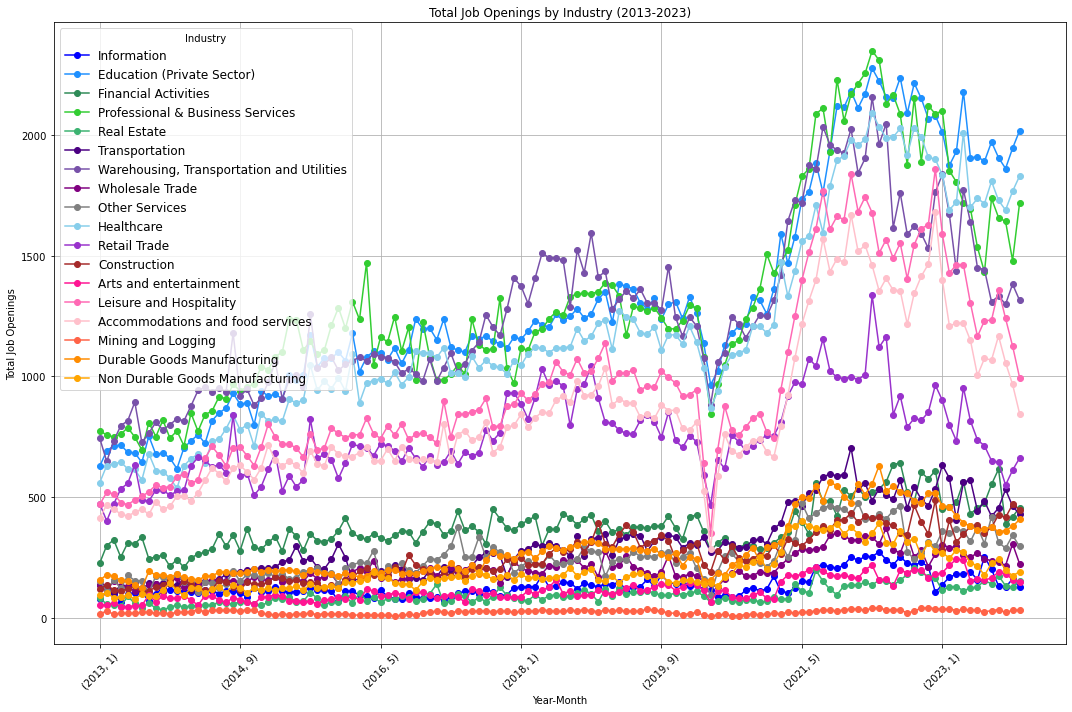

In [40]:
# Plotting job openings over time across industries minus total private 
grouped_df1 = filtered_df.groupby(['industry', 'year', 'month'])['jo'].mean().reset_index()

# Create the pivot table
pivot_df1 = grouped_df1.pivot_table(index=['year', 'month'], columns='industry', values='jo')

# Ensure the columns are ordered consistently with the color mapping
ordered_columns1 = sorted(pivot_df1.columns, key=lambda x: color_mapping.get(x, '#000000'))
pivot_df1 = pivot_df1[ordered_columns1]

# Plotting with color mapping
pivot_df1.plot(figsize=(15, 10), marker='o', color= color_mapping)
plt.title('Total Job Openings by Industry (2013-2023)')
plt.xlabel('Year-Month')
plt.ylabel('Total Job Openings')
plt.legend(title='Industry', bbox_to_anchor=(0, 1), loc='upper left', prop={'size': 12})
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


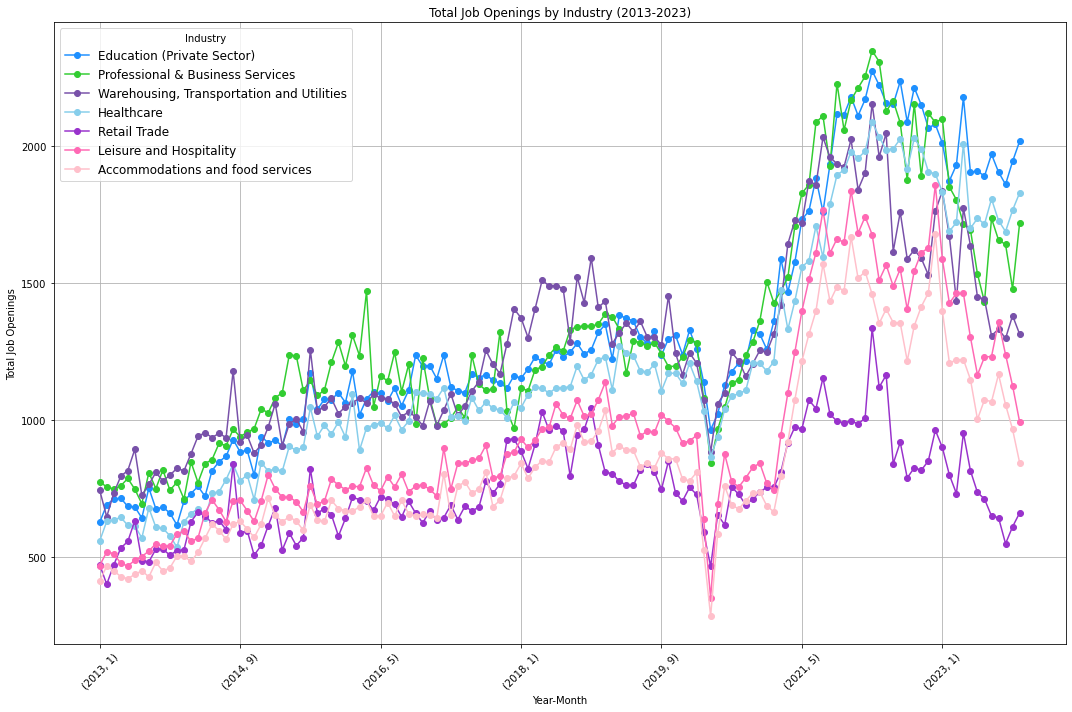

In [44]:
# Plotting job openings in industries with fewer workers for better visualization
grouped_df4 = filtered_df1.groupby(['industry', 'year', 'month'])['jo'].mean().reset_index()
# Recreate the pivot table
pivot_df4 = grouped_df4.pivot_table(index=['year', 'month'], columns='industry', values='jo')

ordered_columns4 = sorted(pivot_df4.columns, key=lambda x: color_mapping.get(x, '#000000'))
pivot_df4 = pivot_df4[ordered_columns4]

pivot_df4.plot(figsize=(15, 10), marker='o', color= color_mapping)
plt.title('Total Job Openings by Industry (2013-2023)')
plt.xlabel('Year-Month')
plt.ylabel('Total Job Openings')
plt.legend(title='Industry', bbox_to_anchor=(0, 1), loc='upper left', prop={'size': 12})
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

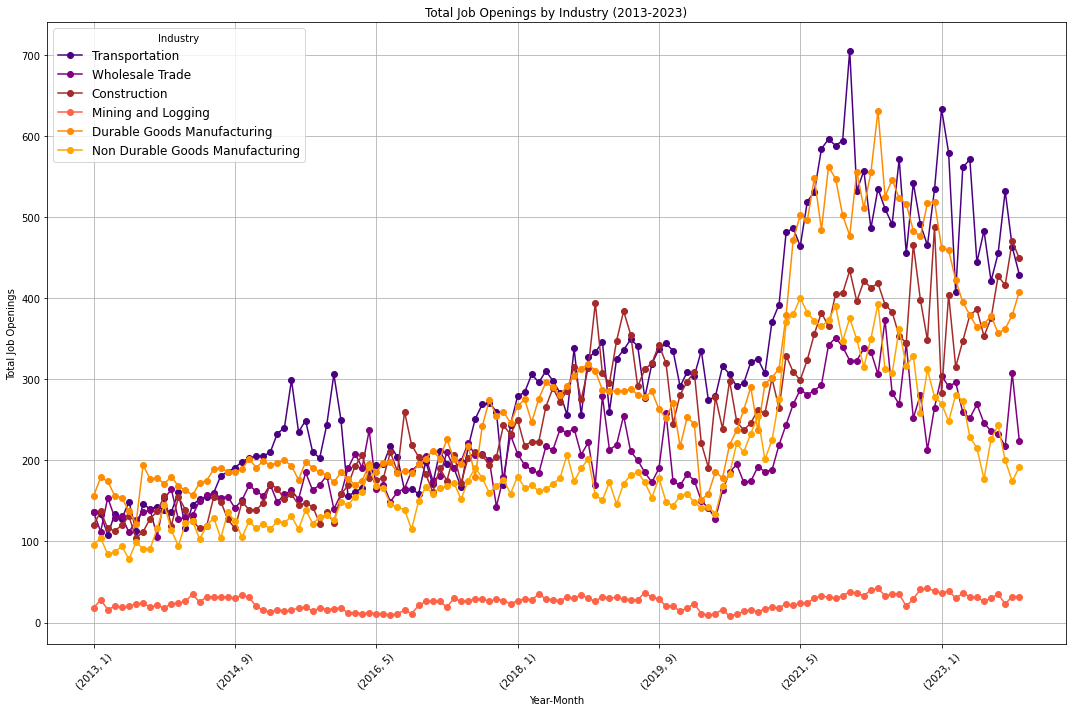

In [42]:
# Plotting manufacturing, minning and logging, construction, wholesale trade and transportation 
grouped_df5 = filtered_df2.groupby(['industry', 'year', 'month'])['jo'].mean().reset_index()
# Recreate the pivot table
pivot_df5 = grouped_df5.pivot_table(index=['year', 'month'], columns='industry', values='jo')

ordered_columns5 = sorted(pivot_df5.columns, key=lambda x: color_mapping.get(x, '#000000'))
pivot_df5 = pivot_df5[ordered_columns5]

pivot_df5.plot(figsize=(15, 10), marker='o', color= color_mapping)
plt.title('Total Job Openings by Industry (2013-2023)')
plt.xlabel('Year-Month')
plt.ylabel('Total Job Openings')
plt.legend(title='Industry', bbox_to_anchor=(0, 1), loc='upper left', prop={'size': 12})
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

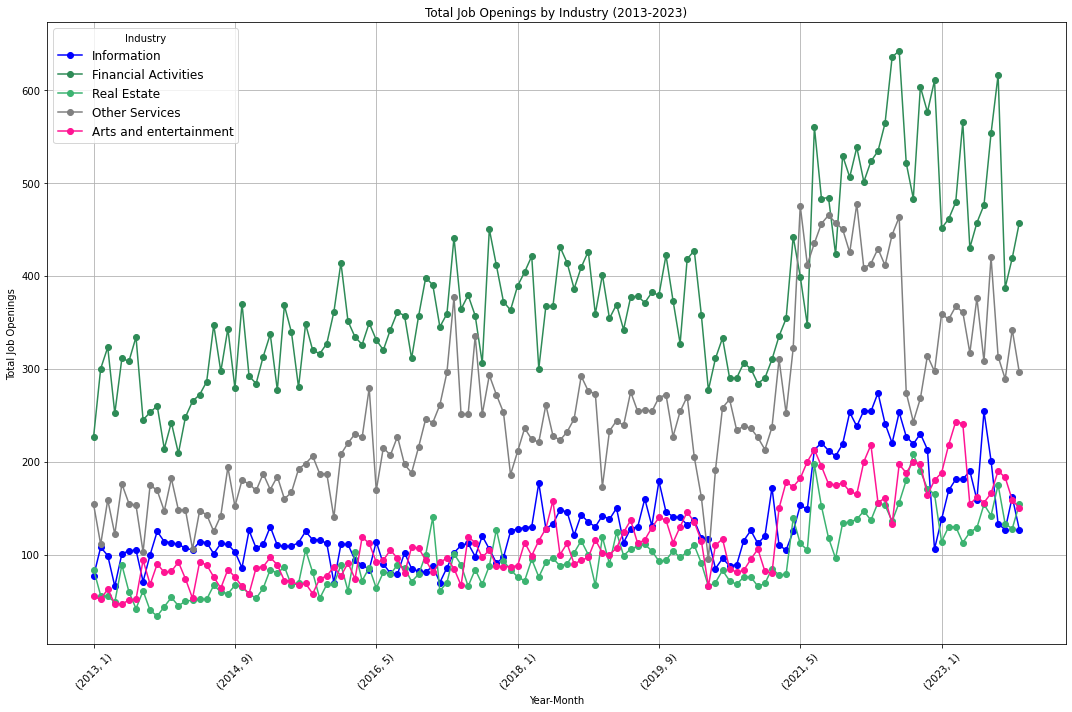

In [43]:
# Plotting financial services, real estate, information, other services and arts and entertainment
grouped_df6 = filtered_df3.groupby(['industry', 'year', 'month'])['jo'].mean().reset_index()
# Recreate the pivot table
pivot_df6 = grouped_df6.pivot_table(index=['year', 'month'], columns='industry', values='jo')

ordered_columns6 = sorted(pivot_df6.columns, key=lambda x: color_mapping.get(x, '#000000'))
pivot_df6 = pivot_df6[ordered_columns6]

pivot_df6.plot(figsize=(15, 10), marker='o', color= color_mapping)
plt.title('Total Job Openings by Industry (2013-2023)')
plt.xlabel('Year-Month')
plt.ylabel('Total Job Openings')
plt.legend(title='Industry', bbox_to_anchor=(0, 1), loc='upper left', prop={'size': 12})
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

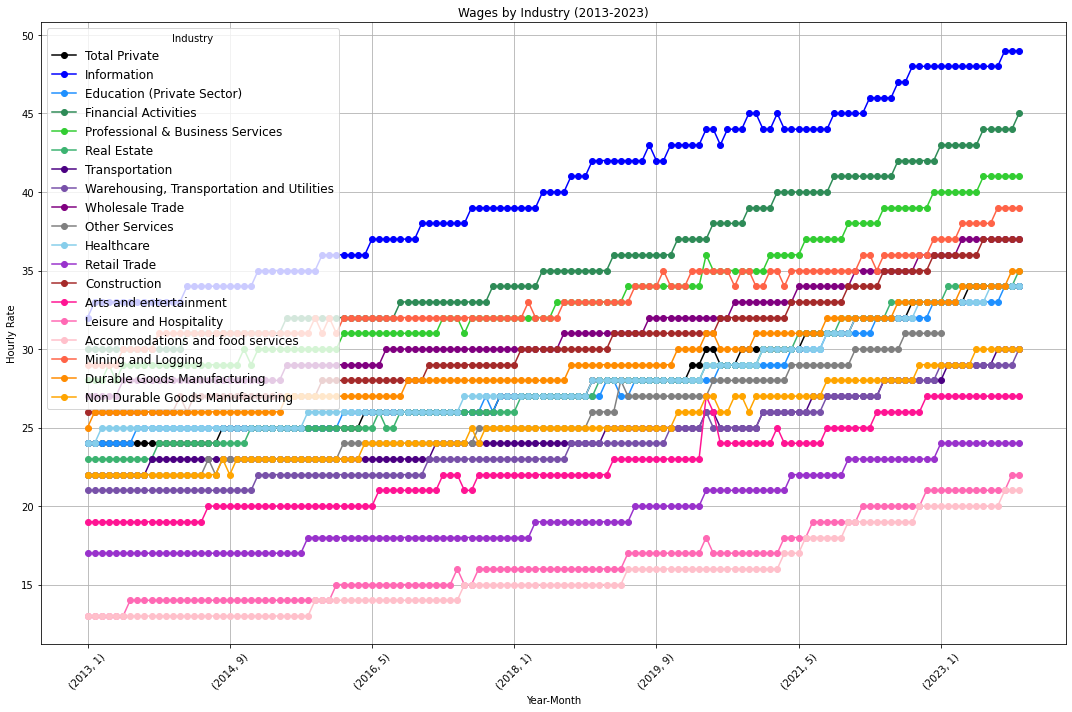

In [13]:
# Plotting wages across industries over time 
grouped_df2 = df.groupby(['industry', 'year', 'month'])['w'].mean().reset_index()

# Recreate the pivot table
pivot_df2 = grouped_df2.pivot_table(index=['year', 'month'], columns='industry', values='w')

ordered_columns2 = sorted(pivot_df2.columns, key=lambda x: color_mapping.get(x, '#000000'))
pivot_df2 = pivot_df2[ordered_columns2]

pivot_df2.plot(figsize=(15, 10), marker='o', color= color_mapping)
plt.title('Wages by Industry (2013-2023)')
plt.xlabel('Year-Month')
plt.ylabel('Hourly Rate')
plt.legend(title='Industry', bbox_to_anchor=(0, 1), loc='upper left', prop={'size': 12})
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


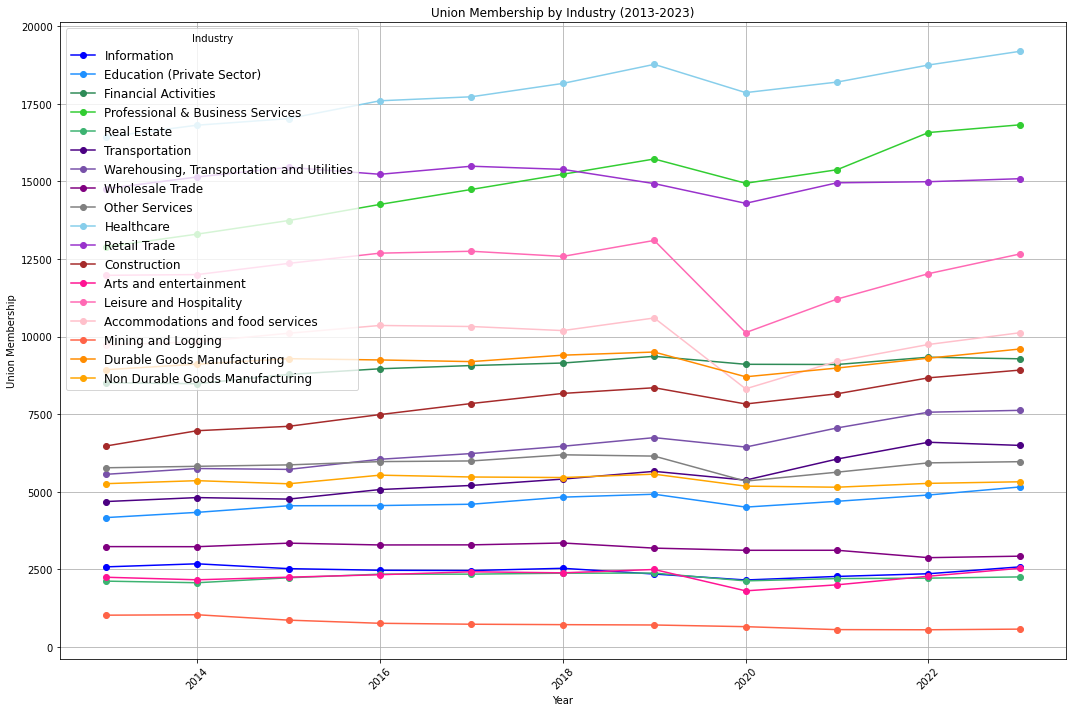

In [14]:
# Plotting union membership over time, only had anual data
grouped_df3 = df.groupby(['industry', 'year', 'month'])['u'].mean().reset_index()

# Recreate the pivot table
pivot_df3 = grouped_df3.pivot_table(index=['year'], columns='industry', values='u')

ordered_columns3 = sorted(pivot_df3.columns, key=lambda x: color_mapping.get(x, '#000000'))
pivot_df3 = pivot_df3[ordered_columns1]

pivot_df3.plot(figsize=(15, 10), marker='o', color= color_mapping)
plt.title('Union Membership by Industry (2013-2023)')
plt.xlabel('Year')
plt.ylabel('Union Membership')
plt.legend(title='Industry', bbox_to_anchor=(0, 1), loc='upper left', prop={'size': 12})
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


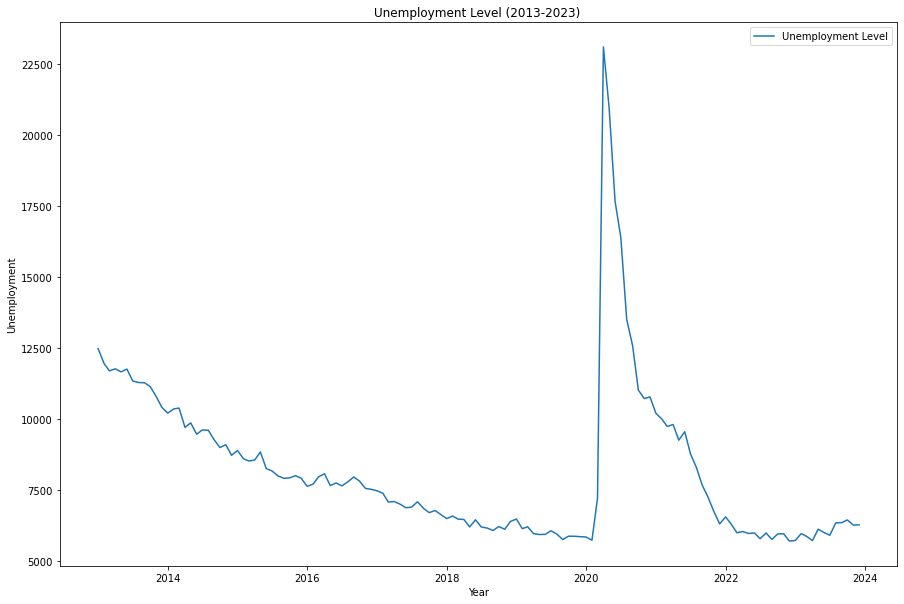

In [15]:
# Plotting unemployment level over time
plt.figure(figsize=(15, 10))

# Sort the DataFrame by the date column
df_sorted = df.sort_values('date')

# Plotting the sorted data

plt.plot(df_sorted['date'], df_sorted['unemployment'], label='Unemployment Level')

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Unemployment')
plt.title('Unemployment Level (2013-2023) ')
plt.legend()

plt.show()

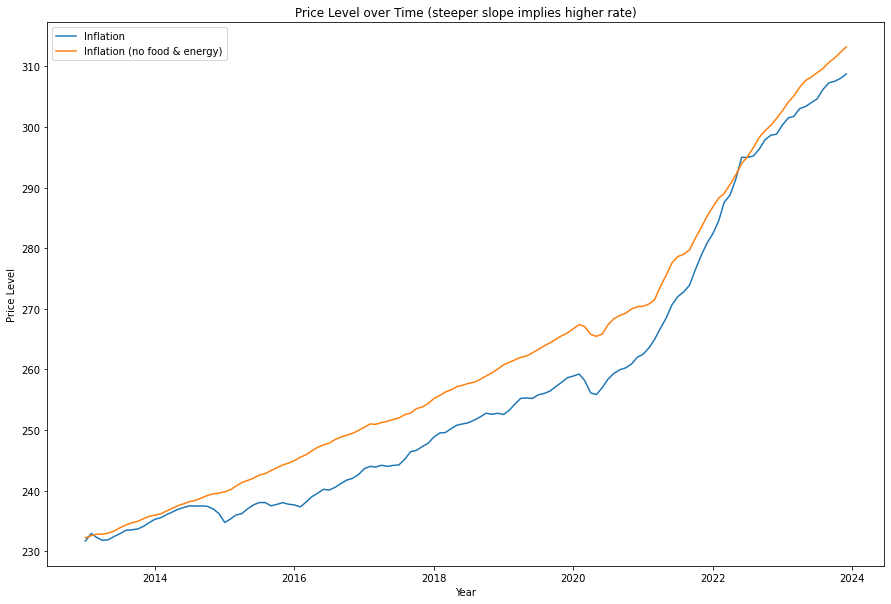

In [16]:
plt.figure(figsize=(15, 10))

# Plotting inflation levels over time 
df_sorted = df.sort_values('date')

# Plotting the sorted data
plt.plot(df_sorted['date'], df_sorted['inflation'], label='Inflation')
plt.plot(df_sorted['date'], df_sorted['inflation_no_f_e'], label='Inflation (no food & energy)')

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Price Level')
plt.title('Price Level over Time (steeper slope implies higher rate)')
plt.legend()

plt.show()


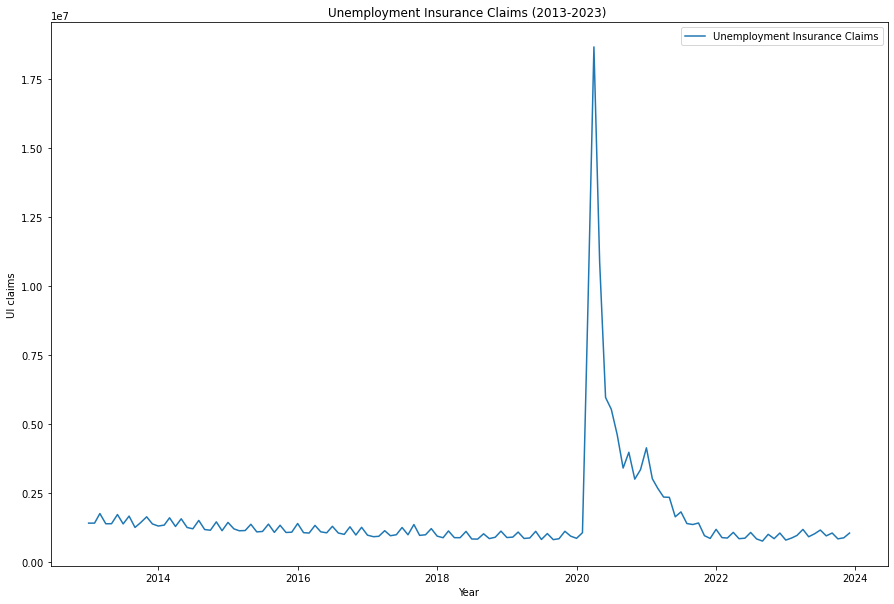

In [17]:
# Plotting unemployment insurance claims over time
plt.figure(figsize=(15, 10))

# Sort the DataFrame by the date column
df_sorted = df.sort_values('date')

# Plotting the sorted data

plt.plot(df_sorted['date'], df_sorted['total_ui_claims'], label='Unemployment Insurance Claims')

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('UI claims')
plt.title('Unemployment Insurance Claims (2013-2023) ')
plt.legend()

plt.show()


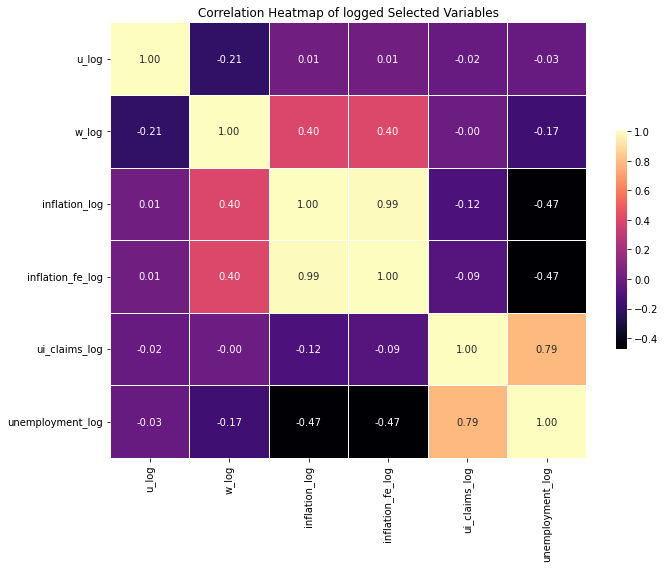

In [18]:
# Creating correlation matrix
cols_of_interest = [ 'u_log', 'w_log', 'inflation_log', 'inflation_fe_log', 'ui_claims_log', 'unemployment_log']
df_selected = df[cols_of_interest]

# Calculate the correlation matrix
corr_matrix = df_selected.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='magma', fmt=".2f", linewidths=.5, cbar_kws={"shrink": .5})

# Adding title and adjusting layout
plt.title('Correlation Heatmap of logged Selected Variables')
plt.tight_layout()

# Display the heatmap
plt.show()

In [19]:
# Run VIF test
X = df[[ 'inflation', 'total_ui_claims', 'u_log', 'w_log']]
X = add_constant(X)  # Adds a constant term to the predictor set

# Drop rows with any NaN values only for the VIF calculation
X_dropna = X.dropna()

# Calculate VIF for each predictor using the temporary DataFrame without NaNs
vif = pd.DataFrame()
vif["variables"] = X_dropna.columns
vif["VIF"] = [variance_inflation_factor(X_dropna.values, i) for i in range(X_dropna.shape[1])]

print(vif)



         variables         VIF
0            const  320.822363
1        inflation    1.202151
2  total_ui_claims    1.003432
3            u_log    1.060400
4            w_log    1.259372


In [20]:
# significant coeficients in each industry show their effect on job openings
for industry, coefs in significant_coefficients.items():
    print(f"Industry: {industry}")
    print(coefs)
    print("\n")

Industry: Total Private
inflation_fe_log                 -2.731467
C(covid)[T.1]:inflation_fe_log   -4.302610
unemployment_log                 -0.928670
C(covid)[T.1]:unemployment_log    0.435115
u_log                             1.756145
C(covid)[T.1]:w_log               3.054216
dtype: float64


Industry: Accommodations and food services
Intercept                         18.927440
inflation_fe_log                   2.434185
C(covid)[T.1]:inflation_fe_log   -14.389053
unemployment_log                  -1.078027
C(covid)[T.1]:unemployment_log     0.612513
u_log                             -1.420655
C(covid)[T.1]:u_log                3.803107
w_log                             -1.153999
C(covid)[T.1]:w_log                7.421926
dtype: float64


Industry: Arts and entertainment
Intercept                        -28.830262
C(covid)[T.1]                     36.445070
inflation_fe_log                   8.437176
C(covid)[T.1]:inflation_fe_log   -10.287907
C(covid)[T.1]:u_log                2

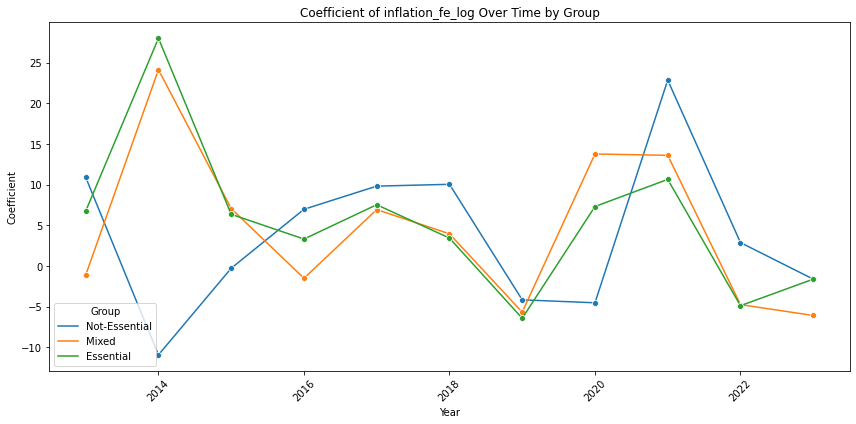

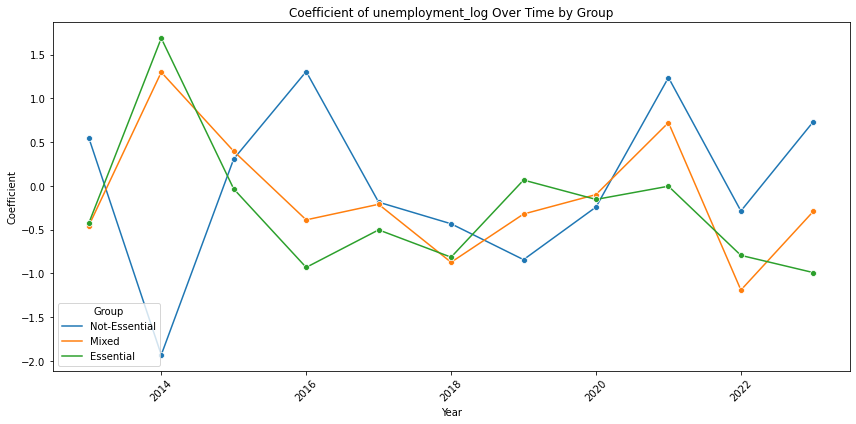

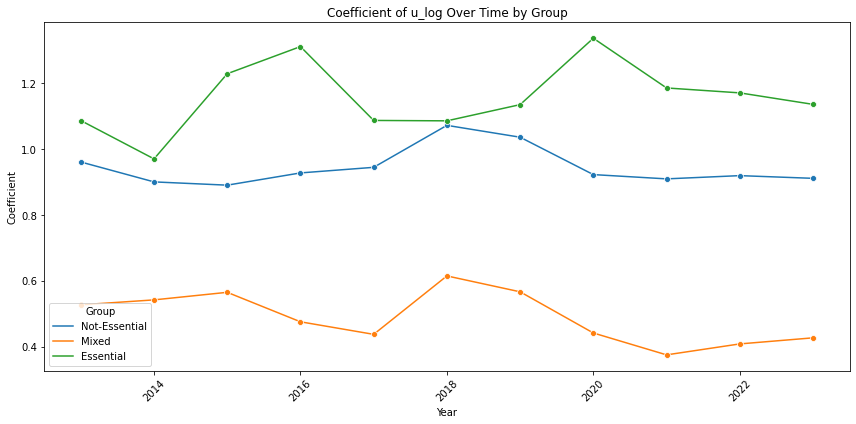

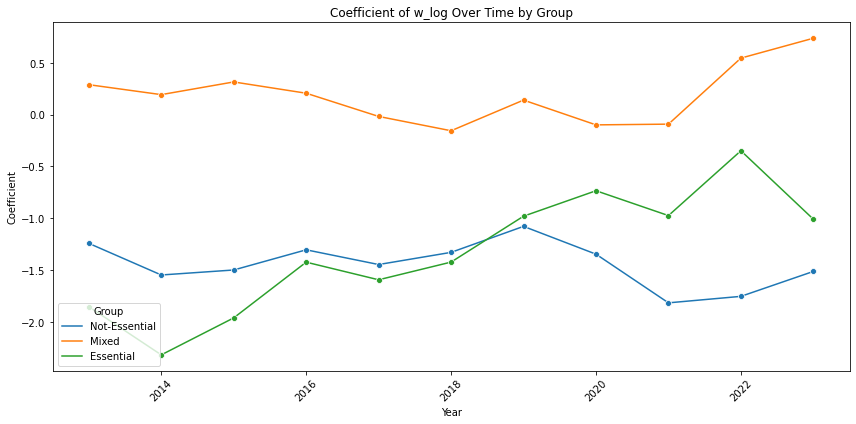

In [21]:
# plotting the effect of each variable on job openings over time for each group 
variables_to_plot = ['inflation_fe_log', 'unemployment_log', 'u_log', 'w_log']
# Plotting each category for each variable
for variable_to_plot in variables_to_plot:
    coefficients_df_filtered = coefficients_df[coefficients_df['variable'] == variable_to_plot]

    plt.figure(figsize=(12, 6))
    sns.lineplot(data=coefficients_df_filtered, x='year', y='coefficient', hue='group', marker='o', linestyle='-')
    plt.title(f'Coefficient of {variable_to_plot} Over Time by Group')
    plt.xlabel('Year')
    plt.ylabel('Coefficient')
    plt.xticks(rotation=45)
    plt.legend(title='Group', loc='lower left')
    plt.tight_layout()
    plt.show()

In [22]:
for industry in df['industry'].unique():
     # Print the summary for each industry's model
    print(f"Industry: {industry}")
    print(model.summary())
    print("\n\n")

Industry: Total Private
                            OLS Regression Results                            
Dep. Variable:                 jo_log   R-squared:                       0.721
Model:                            OLS   Adj. R-squared:                  0.701
Method:                 Least Squares   F-statistic:                     44.26
Date:                Tue, 19 Mar 2024   Prob (F-statistic):           2.58e-34
Time:                        13:11:51   Log-Likelihood:                 65.069
No. Observations:                 132   AIC:                            -110.1
Df Residuals:                     122   BIC:                            -81.31
Df Model:                           9                                         
Covariance Type:                  HC1                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------

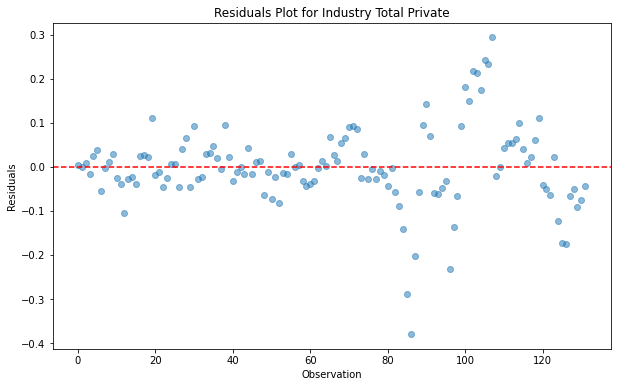

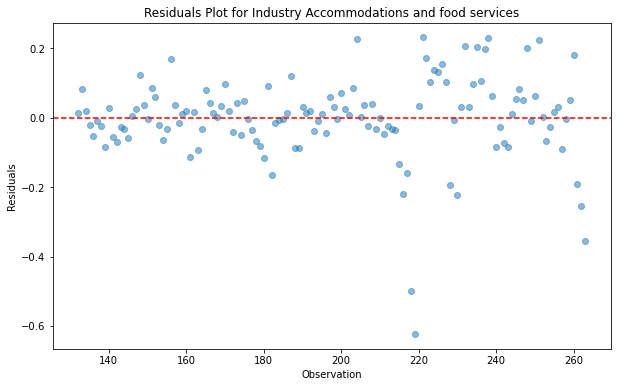

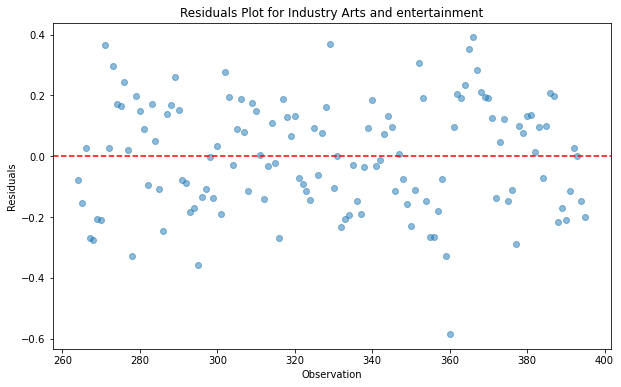

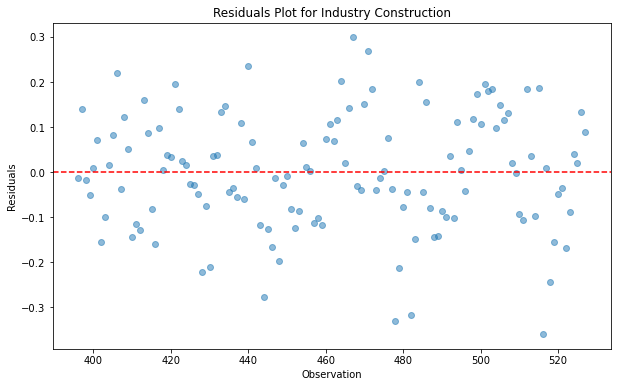

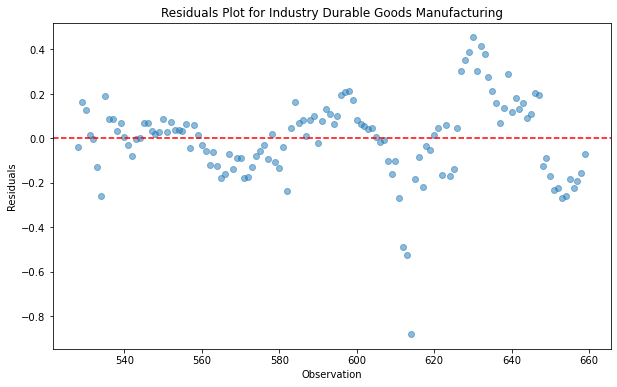

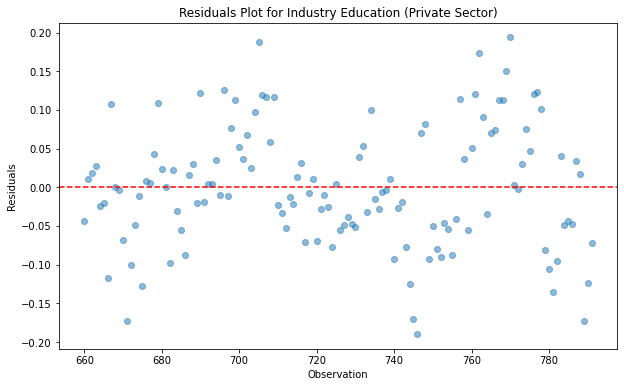

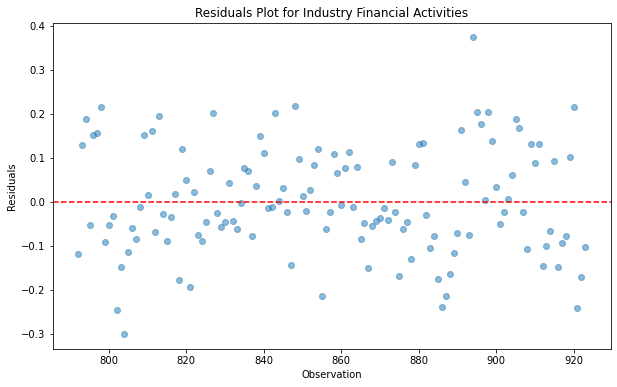

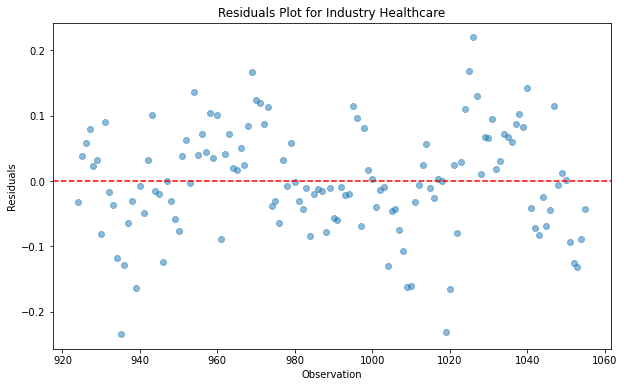

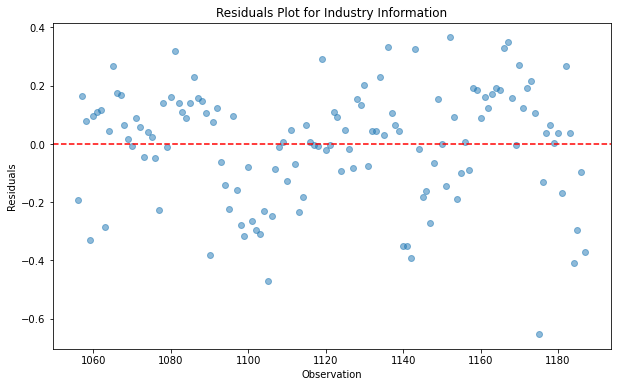

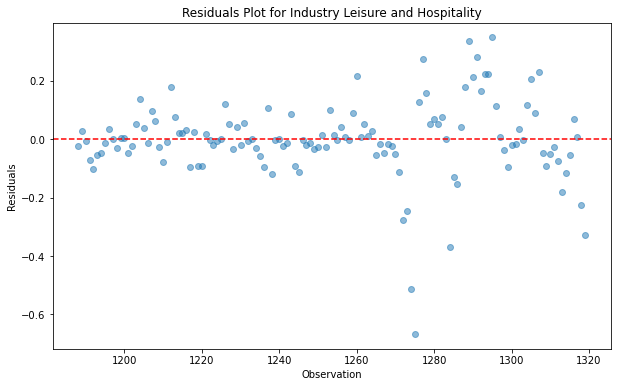

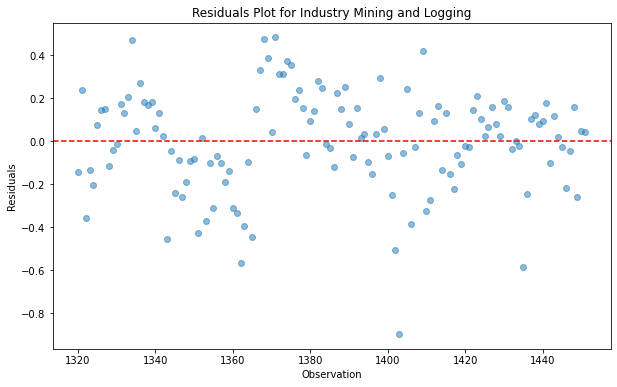

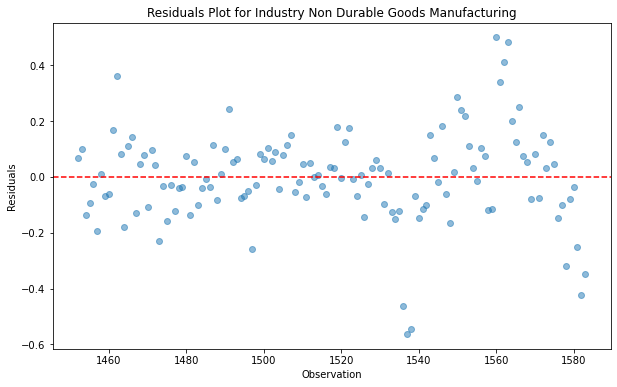

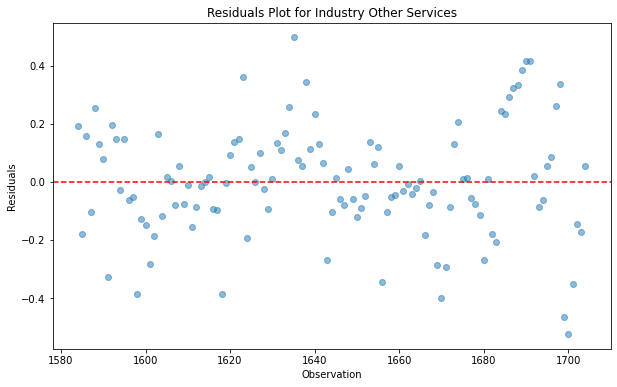

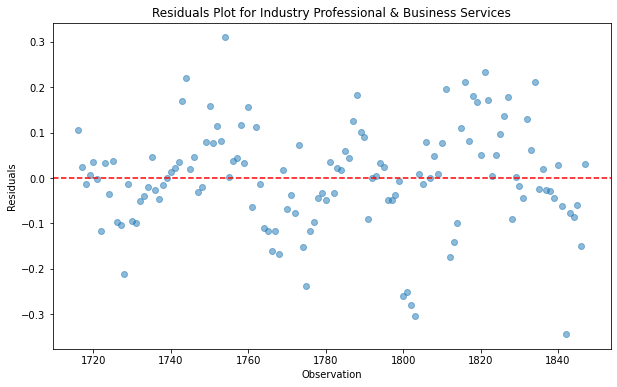

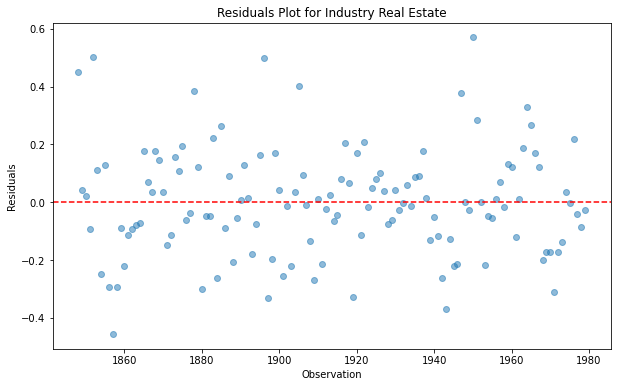

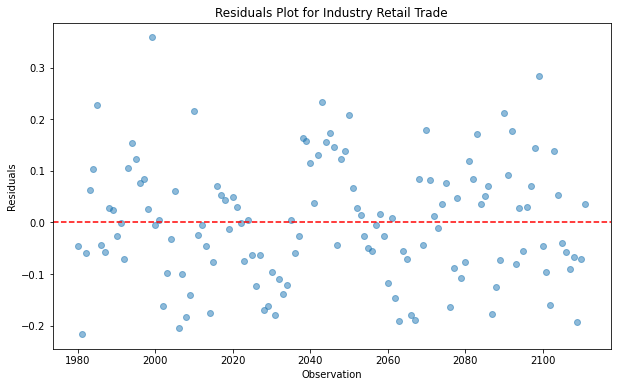

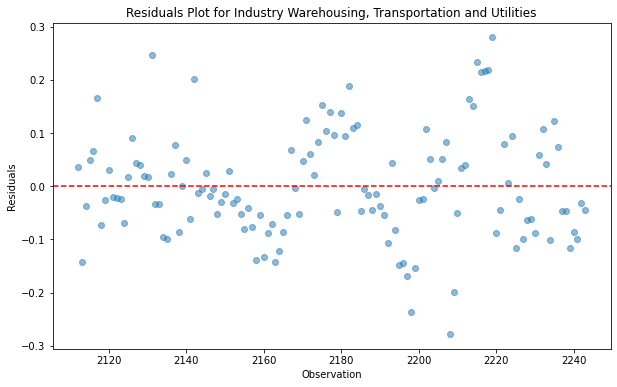

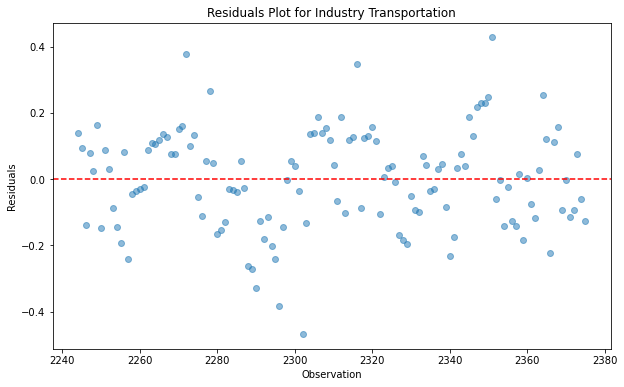

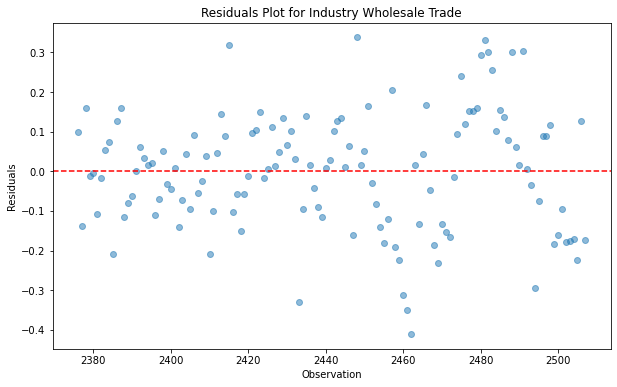

In [23]:
# Iterate plotting residuals
for industry in df['industry'].unique():
    
    df_industry = df[df['industry'] == industry].copy()

    formula = ('jo_log ~ C(covid) * inflation_fe_log + '
               'C(covid) * unemployment_log + '
               'C(covid) * u_log + '
               'C(covid) * w_log')
    model = smf.ols(formula, data=df_industry).fit(cov_type='HC1')

    # Calculate residuals
    df_industry['residuals'] = model.resid

    # Plotting residuals
    plt.figure(figsize=(10, 6))
    plt.scatter(df_industry.index, df_industry['residuals'], alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Observation')
    plt.ylabel('Residuals')
    plt.title(f'Residuals Plot for Industry {industry}')
    plt.show()


In [24]:
# Regressing covid and unemployment on union membership
# Iterate through each industry and run separate regressions
for industry in df['industry'].unique():
    df_industry = df[df['industry'] == industry].copy()
    formula = ('u_log ~ C(covid) * unemployment_log')
    # Fit the model with robust standard errors
    model = smf.ols(formula, data=df_industry).fit(cov_type='HC1')

    # Print the summary for each industry's model
    print(f"Industry: {industry}")
    print(model.summary())
    print("\n\n")


Industry: Total Private
                            OLS Regression Results                            
Dep. Variable:                  u_log   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     607.8
Date:                Tue, 19 Mar 2024   Prob (F-statistic):           1.67e-75
Time:                        13:11:54   Log-Likelihood:                 355.74
No. Observations:                 132   AIC:                            -703.5
Df Residuals:                     128   BIC:                            -692.0
Df Model:                           3                                         
Covariance Type:                  HC1                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------

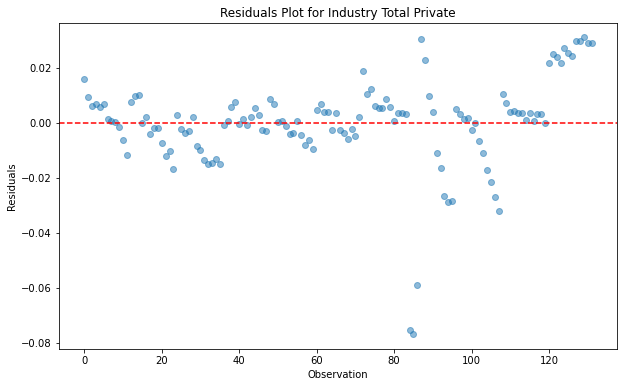

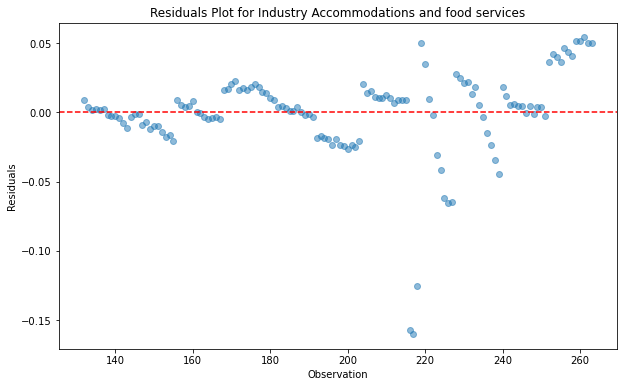

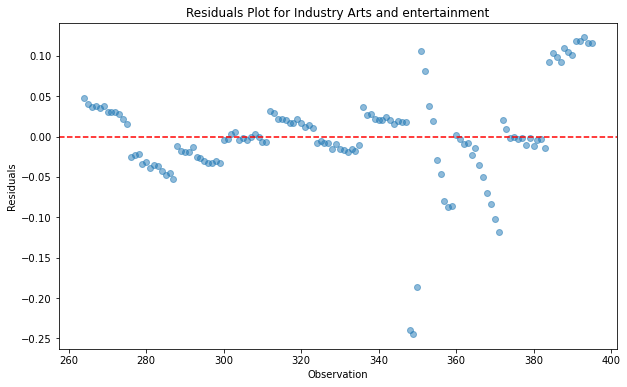

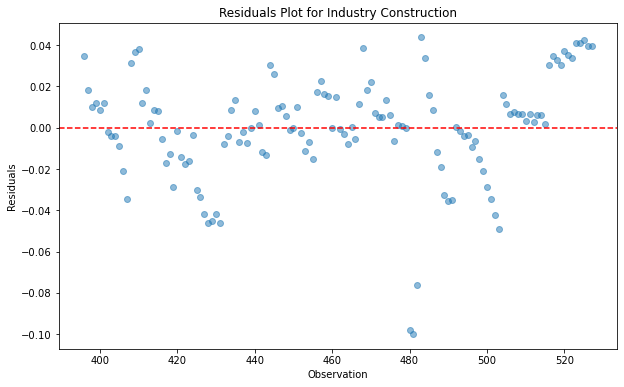

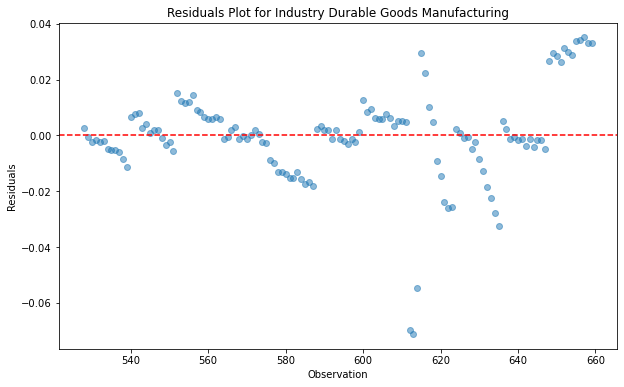

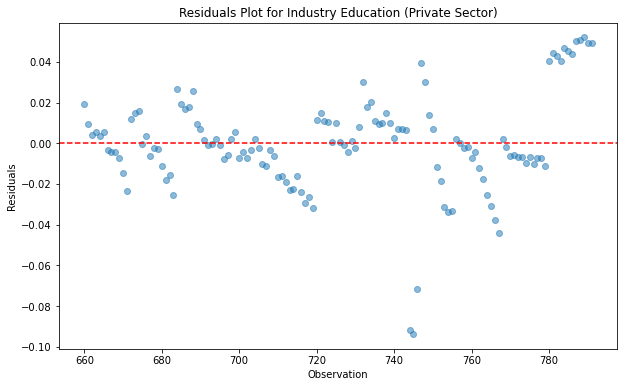

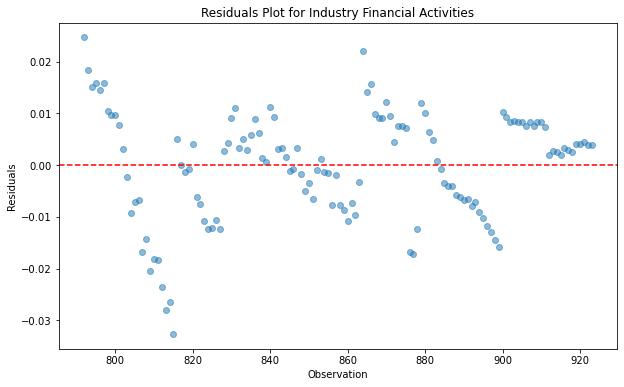

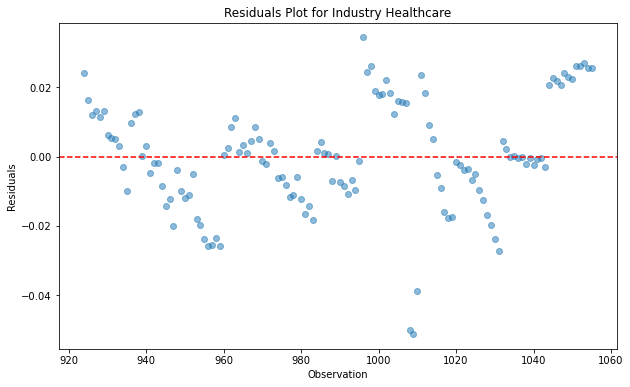

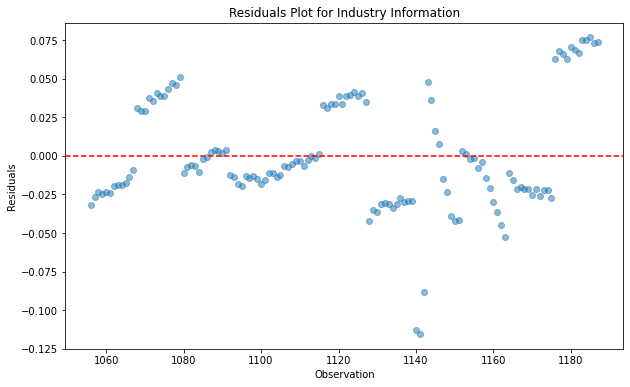

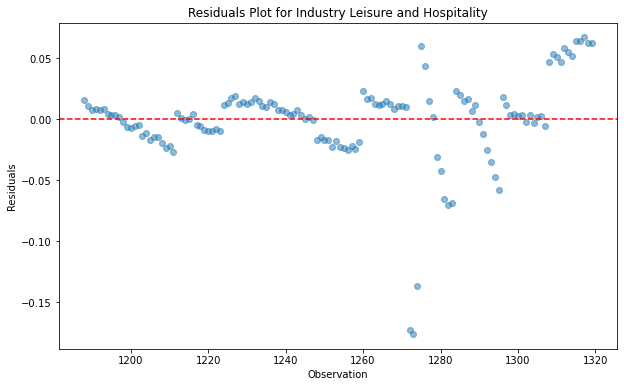

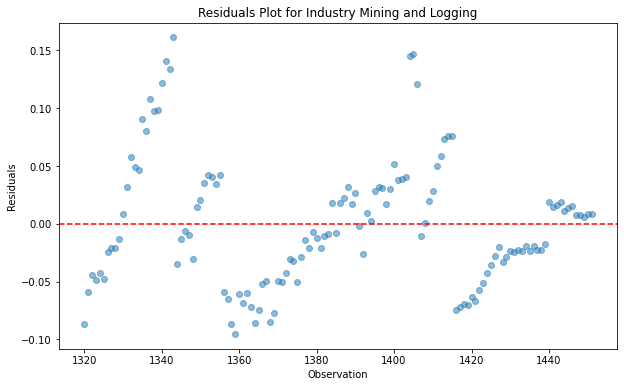

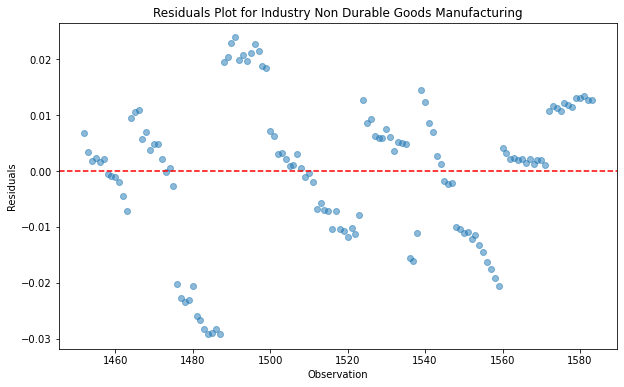

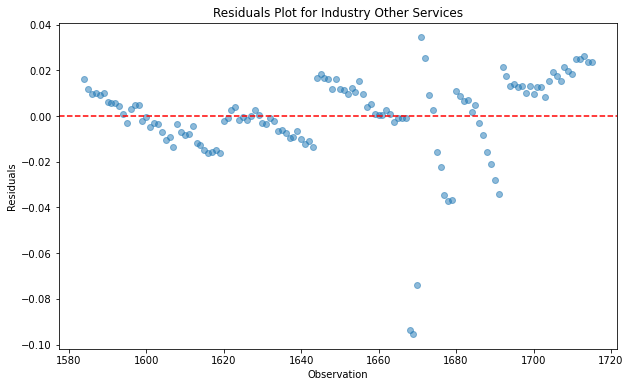

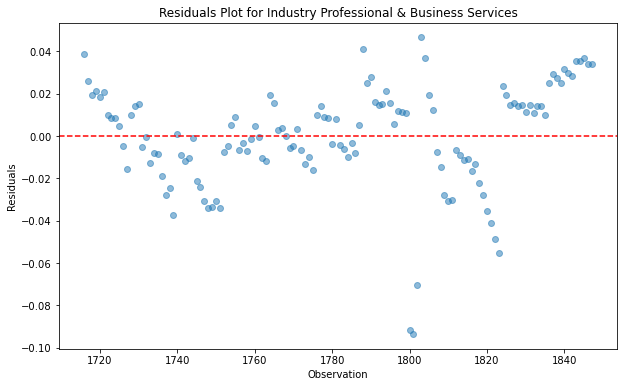

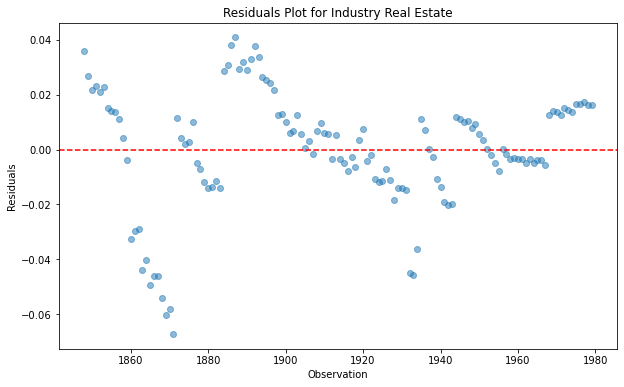

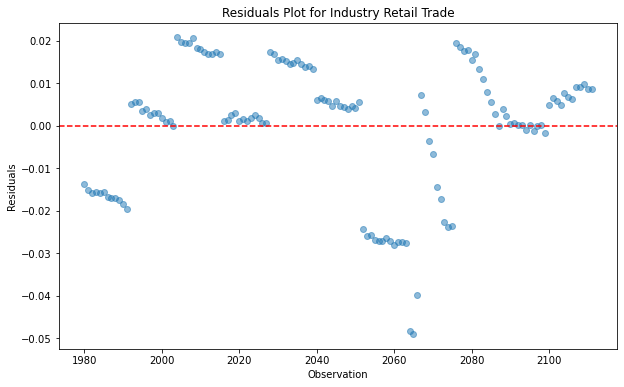

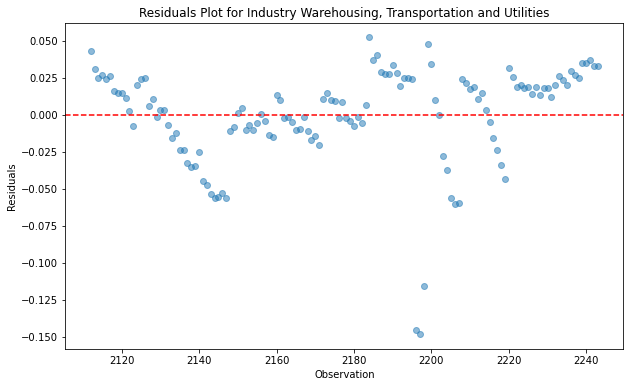

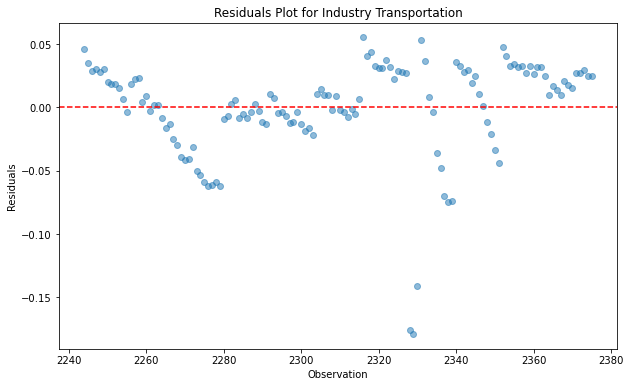

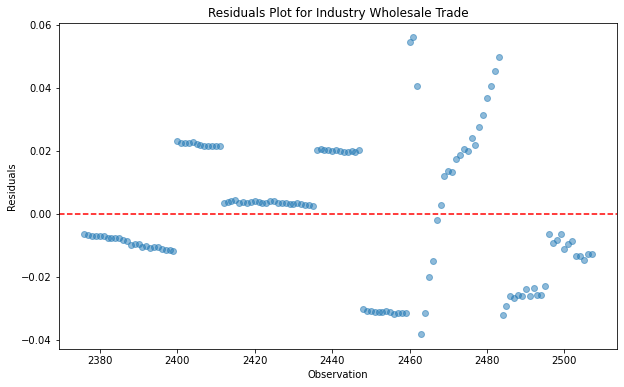

In [25]:
for industry in df['industry'].unique():
    # Filter the DataFrame for the current industry
    df_industry = df[df['industry'] == industry].copy()
    formula = ('u_log ~ C(covid) * unemployment_log')
    
    # Fit the model with robust standard errors
    model = smf.ols(formula, data=df_industry).fit(cov_type='HC1')
    
    # Calculate residuals
    df_industry['residuals'] = model.resid

    # Plotting residuals
    plt.figure(figsize=(10, 6))
    plt.scatter(df_industry.index, df_industry['residuals'], alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Observation')
    plt.ylabel('Residuals')
    plt.title(f'Residuals Plot for Industry {industry}')
    plt.show()